In [1]:
# Library Imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler,LabelEncoder 
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import StratifiedShuffleSplit, cross_val_predict, GridSearchCV
from pandas.plotting import scatter_matrix
from sklearn.metrics import f1_score,precision_score,roc_auc_score,confusion_matrix,recall_score

from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier

In [2]:
csv_path =  '../datasets/public_dataset/emp_attrition.csv'
attrition = pd.read_csv(csv_path)

In [3]:
attrition.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
Age                         1470 non-null int64
Attrition                   1470 non-null object
BusinessTravel              1470 non-null object
DailyRate                   1470 non-null int64
Department                  1470 non-null object
DistanceFromHome            1470 non-null int64
Education                   1470 non-null int64
EducationField              1470 non-null object
EmployeeCount               1470 non-null int64
EmployeeNumber              1470 non-null int64
EnvironmentSatisfaction     1470 non-null int64
Gender                      1470 non-null object
HourlyRate                  1470 non-null int64
JobInvolvement              1470 non-null int64
JobLevel                    1470 non-null int64
JobRole                     1470 non-null object
JobSatisfaction             1470 non-null int64
MaritalStatus               1470 non-null object
MonthlyIncome         

In [4]:
attrition = attrition.drop(['Over18','BusinessTravel','DailyRate','DistanceFromHome','EducationField','EmployeeCount','EmployeeNumber','MonthlyRate','StandardHours','StockOptionLevel','Department','JobRole','OverTime','HourlyRate'],axis=1)

In [5]:
attrition.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 21 columns):
Age                         1470 non-null int64
Attrition                   1470 non-null object
Education                   1470 non-null int64
EnvironmentSatisfaction     1470 non-null int64
Gender                      1470 non-null object
JobInvolvement              1470 non-null int64
JobLevel                    1470 non-null int64
JobSatisfaction             1470 non-null int64
MaritalStatus               1470 non-null object
MonthlyIncome               1470 non-null int64
NumCompaniesWorked          1470 non-null int64
PercentSalaryHike           1470 non-null int64
PerformanceRating           1470 non-null int64
RelationshipSatisfaction    1470 non-null int64
TotalWorkingYears           1470 non-null int64
TrainingTimesLastYear       1470 non-null int64
WorkLifeBalance             1470 non-null int64
YearsAtCompany              1470 non-null int64
YearsInCurrentRole        

In [6]:
categorical = ['Attrition','Gender','MaritalStatus']

for cat in categorical:
    print(attrition[cat].value_counts(),'\n')

No     1233
Yes     237
Name: Attrition, dtype: int64 

Male      882
Female    588
Name: Gender, dtype: int64 

Married     673
Single      470
Divorced    327
Name: MaritalStatus, dtype: int64 



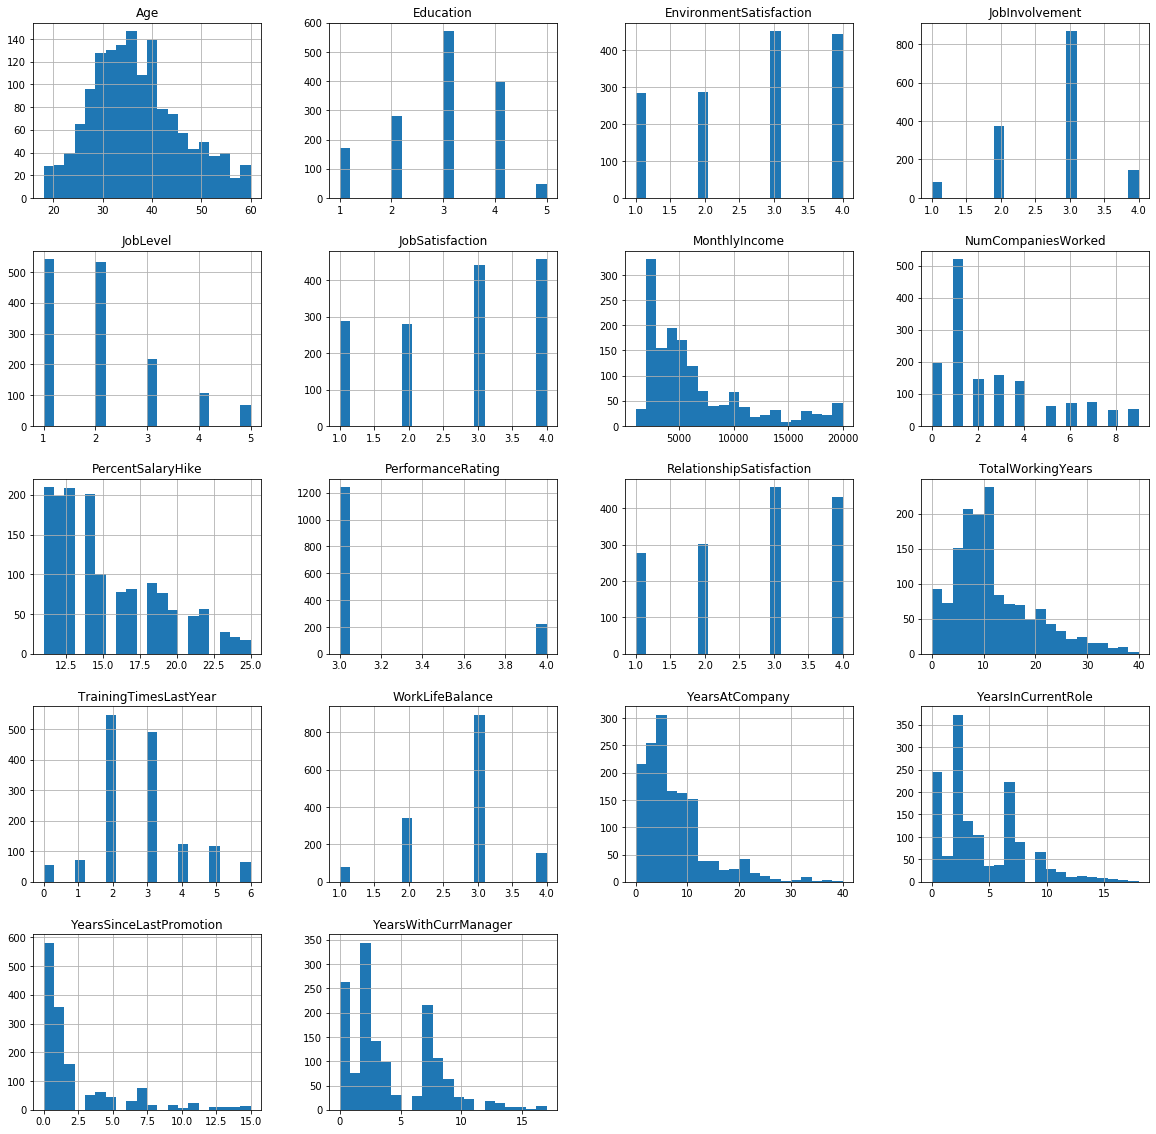

In [7]:
%matplotlib inline
attrition.hist(bins=20, figsize=(20,20))
plt.show()

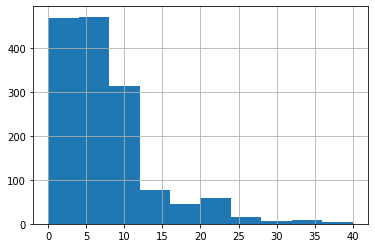

In [8]:
# Salary and Years at Company Categories

attrition['YearsAtCompany'].hist()

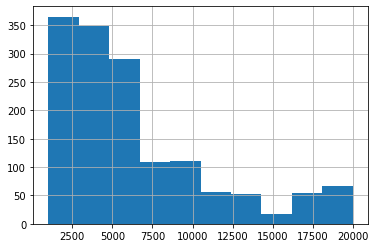

In [9]:
attrition['MonthlyIncome'].hist()

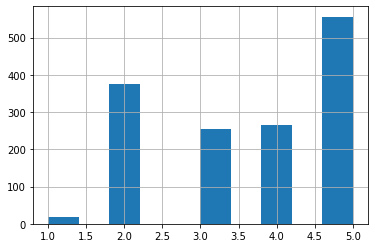

In [10]:
attrition['MonthlyIncome_cat'] = np.ceil(attrition['MonthlyIncome']/1500)
attrition['MonthlyIncome_cat'].where(attrition['MonthlyIncome_cat']<5,5.0,inplace = True )
attrition['MonthlyIncome_cat'].hist()

In [11]:
split = StratifiedShuffleSplit(n_splits = 1, test_size= 0.2, random_state=42)
for train_index, test_index in split.split(attrition,  attrition['MonthlyIncome_cat']):
    strat_train_set = attrition.loc[train_index]
    strat_test_set = attrition.loc[test_index]

In [12]:
strat_train_set['MonthlyIncome_cat'].value_counts()/len(strat_train_set)

5.0    0.378401
2.0    0.255952
4.0    0.180272
3.0    0.172619
1.0    0.012755
Name: MonthlyIncome_cat, dtype: float64

In [13]:
attrition['MonthlyIncome_cat'].value_counts()/len(attrition)

5.0    0.378231
2.0    0.255782
4.0    0.180272
3.0    0.172789
1.0    0.012925
Name: MonthlyIncome_cat, dtype: float64

In [14]:
for set_ in (strat_train_set,strat_test_set):
    set_.drop('MonthlyIncome_cat',axis=1,inplace=True)

In [15]:
attrition = strat_train_set.copy()

In [16]:
attrition = strat_train_set.drop('Attrition',axis=1)
attrition_labels = strat_train_set['Attrition'].copy()

In [17]:
# Find Columns with null values
attrition_incomplete_rows = attrition[attrition.isnull().any(axis=1)].head()
attrition_incomplete_rows.shape

(0, 20)

In [18]:
attrition_num = attrition.drop(['Gender','MaritalStatus'], axis=1)

num_attribs = list(attrition_num)
cat_attribs = ['Gender','MaritalStatus']

full_pipeline = ColumnTransformer([
    ('num',StandardScaler(),num_attribs),
    ('cat',OneHotEncoder(),cat_attribs)
])


attrition_prepared = full_pipeline.fit_transform(attrition)

In [19]:
attrition_prepared.shape


(1176, 23)

In [20]:
attrition_prepared_dataframe = pd.DataFrame(
    attrition_prepared,
    columns = list(attrition_num) + ['Female','Male','Divorced','Married','Single'],
    index = attrition_num.index
)

In [21]:
attrition.head()

,Age,Education,EnvironmentSatisfaction,Gender,JobInvolvement,JobLevel,JobSatisfaction,MaritalStatus,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
980,31,3,3,Female,2,1,4,Single,2785,7,14,3,3,3,3,4,1,0,0,0
644,31,4,4,Male,3,1,4,Married,2356,3,19,3,2,8,2,3,6,4,0,2
1115,34,4,1,Male,3,1,4,Single,2972,1,13,3,3,1,4,1,1,0,0,0
1110,35,3,1,Female,3,1,1,Divorced,2074,1,12,3,4,1,2,3,1,0,0,0
121,33,2,3,Male,3,2,2,Married,6146,0,13,3,1,8,2,4,7,7,0,7


In [22]:
attrition_prepared_dataframe.head()


,Age,Education,EnvironmentSatisfaction,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,PerformanceRating,...,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Female,Male,Divorced,Married,Single
980,-0.658172,0.062354,0.252426,-1.050133,-0.961110,1.167525,-0.794815,1.694930,-0.344360,-0.42929,...,1.784922,-0.960679,-1.156362,-0.673554,-1.147887,1.0,0.0,0.0,0.0,1.0
644,-0.658172,1.040071,1.171477,0.375914,-0.961110,1.167525,-0.886106,0.100021,1.025626,-0.42929,...,0.362789,-0.145675,-0.041933,-0.673554,-0.581766,0.0,1.0,0.0,1.0,0.0
1115,-0.331998,1.040071,-1.585676,0.375914,-0.961110,1.167525,-0.755022,-0.697434,-0.618358,-0.42929,...,-2.481477,-0.960679,-1.156362,-0.673554,-1.147887,0.0,1.0,0.0,0.0,1.0
1110,-0.223274,0.062354,-1.585676,0.375914,-0.961110,-1.549512,-0.946115,-0.697434,-0.892355,-0.42929,...,0.362789,-0.960679,-1.156362,-0.673554,-1.147887,1.0,0.0,1.0,0.0,0.0
121,-0.440723,-0.915362,0.252426,0.375914,-0.063362,-0.643833,-0.079599,-1.096161,-0.618358,-0.42929,...,1.784922,0.017326,0.793888,-0.673554,0.833536,0.0,1.0,0.0,1.0,0.0


In [23]:
gnb = GaussianNB()
gnb.fit(attrition_prepared,attrition_labels)

GaussianNB(priors=None, var_smoothing=1e-09)

In [24]:
some_data  = attrition[:20]
some_labels = attrition_labels[:20]
some_data_prepared = full_pipeline.transform(some_data)

print('', gnb.predict_proba(some_data_prepared))
print('', gnb.predict(some_data_prepared))
print('',list(some_labels))

 [[9.84996284e-02 9.01500372e-01]
 [7.92947667e-01 2.07052333e-01]
 [2.69744970e-02 9.73025503e-01]
 [5.18215901e-01 4.81784099e-01]
 [8.84178202e-01 1.15821798e-01]
 [8.27358545e-01 1.72641455e-01]
 [9.78845852e-01 2.11541476e-02]
 [9.99819095e-01 1.80905189e-04]
 [7.88440972e-01 2.11559028e-01]
 [9.99999256e-01 7.43952679e-07]
 [5.44125056e-01 4.55874944e-01]
 [5.58007879e-01 4.41992121e-01]
 [5.07375863e-01 4.92624137e-01]
 [7.06071190e-01 2.93928810e-01]
 [3.60285565e-01 6.39714435e-01]
 [2.63017654e-01 7.36982346e-01]
 [9.70324261e-01 2.96757391e-02]
 [8.65063249e-02 9.13493675e-01]
 [9.29176431e-01 7.08235691e-02]
 [9.99316672e-01 6.83327591e-04]]
 ['Yes' 'No' 'Yes' 'No' 'No' 'No' 'No' 'No' 'No' 'No' 'No' 'No' 'No' 'No'
 'Yes' 'Yes' 'No' 'Yes' 'No' 'No']
 ['Yes', 'No', 'No', 'Yes', 'No', 'Yes', 'No', 'No', 'No', 'No', 'No', 'No', 'Yes', 'No', 'No', 'No', 'No', 'Yes', 'No', 'No']


In [25]:
f1_score(list(some_labels),gnb.predict(some_data_prepared),average='macro')

0.6000000000000001

In [26]:
dtc = DecisionTreeClassifier()
dtc.fit(attrition_prepared,attrition_labels)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [27]:
f1_score(list(some_labels),dtc.predict(some_data_prepared),average='macro')

1.0

In [28]:
le = LabelEncoder()
le.fit(['Yes','No'])

def evaluateModel(Y_true,Y_predict):
#     Y_true=le.transform(Y_true)
#     Y_predict = le.transform(Y_predict)
    print('******************************************')
    print('PRECISION:',precision_score(Y_true,Y_predict))
    print('RECALL_SCORE ',recall_score(Y_true,Y_predict))
    print('F1 SCORE:',f1_score(Y_true,Y_predict,average='micro'))
    print('ROC_AUC ',roc_auc_score(Y_true,Y_predict))
 
        

In [29]:
evaluateModel(list(attrition_labels),cross_val_predict(dtc,attrition_prepared,attrition_labels,cv=3))
evaluateModel(list(attrition_labels),cross_val_predict(gnb,attrition_prepared,attrition_labels,cv=3))
evaluateModel(list(attrition_labels),cross_val_predict(gnb,attrition_prepared,attrition_labels,cv=10))


******************************************


C:\Users\thilakshi_f\AppData\Local\Continuum\anaconda3\envs\intern1\lib\site-packages\sklearn\metrics\classification.py:1243: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if pos_label not in present_labels:


ValueError: pos_label=1 is not a valid label: array(['No', 'Yes'], dtype='<U3')

In [ ]:
y_train_pred = cross_val_predict(gnb,attrition_prepared,attrition_labels,cv=3)
confusion_matrix(attrition_labels,y_train_pred)

In [ ]:
sgdc = SGDClassifier()
sgdc.fit(attrition_prepared, attrition_labels)
evaluateModel(list(attrition_labels),cross_val_predict(sgdc,attrition_prepared,attrition_labels,cv=15))

In [ ]:
rfc = RandomForestClassifier()
rfc.fit(attrition_prepared,attrition_labels)
evaluateModel(list(attrition_labels),cross_val_predict(rfc,attrition_prepared,attrition_labels,cv=12))

In [ ]:
gbc2 = GradientBoostingClassifier()
evaluateModel(list(attrition_labels),cross_val_predict(gbc2,attrition_prepared,attrition_labels,cv=12))

In [ ]:
evaluateModel(list(attrition_labels),cross_val_predict(gnb,attrition_prepared,attrition_labels,cv=12))
evaluateModel(list(attrition_labels),cross_val_predict(sgdc,attrition_prepared,attrition_labels,cv=12))
evaluateModel(list(attrition_labels),cross_val_predict(rfc,attrition_prepared,attrition_labels,cv=12))

In [ ]:
rfc.get_params
param_grid = [
    {'n_estimators':[3,10,30], 'max_features':[2,4,6,8]},
    {'bootstrap':[False],'n_estimators':[3,10],'max_features':[2,3,4]}
]

grid_search = GridSearchCV(rfc,param_grid,cv=5,scoring='precision',return_train_score=True)
grid_search.fit(attrition_prepared,le.transform(attrition_labels))


In [ ]:
grid_search.best_params_

In [ ]:
forest_classifier = RandomForestClassifier(max_features=4, n_estimators=10)

In [ ]:
forest_classifier.fit(attrition_prepared,attrition_labels)

In [ ]:
evaluateModel(attrition_labels,forest_classifier.predict(attrition_prepared))

In [ ]:
print('PREDICTION:',forest_classifier.predict(some_data_prepared))
print('TRUE: ',list(some_labels))

In [ ]:
grid_search.best_estimator_

In [ ]:
grid_search.best_estimator_.feature_importances_

In [ ]:
sorted(zip(grid_search.best_estimator_.feature_importances_,list(attrition_prepared_dataframe),),reverse=True)

In [ ]:
# Testing on Test Set
final_model = grid_search.best_estimator_
attrition_test = strat_test_set.drop('Attrition',axis=1)
attrition_test_labels = strat_test_set['Attrition'].copy()

attrition_test_prepared =  full_pipeline.transform(attrition_test)

final_predictions = final_model.predict(attrition_test_prepared)

evaluateModel(le.transform(list(attrition_test_labels)),final_predictions)